# Tugas Besar 1 IF3270 Pembelajaran Mesin

Group13 - K03:
1. 13522129 Hugo Sabam Augusto
2. 13522136 Muhammad Zaki
3. 13522137 Ahmad Rafi Maliki



## Import Libraries

In [2]:
from lib.MLP import *
from lib.Graph import *
from lib.Util import normalize, one_hot_encode

import random

import math
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load mnist_784 dataset

In [3]:
start_time = time.time()

mnist = fetch_openml('mnist_784', version=1, parser='auto')
print(f"Data loaded in {time.time() - start_time:.2f} seconds")
print(f"Data shape: {mnist.data.shape}")

Data loaded in 5.08 seconds
Data shape: (70000, 784)


In [4]:
# TRAIN_DATA_SIZE = 60000
# TEST_SIZE = mnist.data.shape[0] - TRAIN_DATA_SIZE
X, y = mnist.data, mnist.target.astype(int)
X = normalize(X)
y = one_hot_encode(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Finished processing dataset {time.time() - start_time:.2f} seconds\n(1) {X_train.shape[0]} training samples\n(2) {X_test.shape[0]} test samples")

Finished processing dataset 8.53 seconds
(1) 49000 training samples
(2) 21000 test samples


In [5]:
#Train model 


hidden_layer_1 = Layer(input_size=784, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=10, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')

layers = [hidden_layer_1, hidden_layer_2, output_layer]

mlp = MLP(layers=layers, loss_function='cce', lr=0.01)

mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20, batch_size=100)

test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")


Training: 100%|██████████| 20/20 [00:10<00:00,  1.88epoch/s, accuracy=87.59%, train_loss=0.4361, val_loss=0.4575]

Test Accuracy: 87.09%


In [6]:
print("\nEvaluating original model...")
original_predictions = mlp.predict(X_test[:100])
y_test_indices = np.argmax(y_test[:100], axis=1)
original_accuracy = accuracy_score(y_test_indices, original_predictions)
print(f"Original model accuracy: {original_accuracy:.4f}")

print("\nSaving model...")
save_path = 'mnist_model.pkl'
mlp.save(save_path)
print(f"Model saved to {save_path}")

print("\nLoading model...")
loaded_model = MLP.load(save_path)

print("\nValidating loaded model...")
loaded_predictions = loaded_model.predict(X_test[:100])
loaded_accuracy = accuracy_score(y_test_indices, loaded_predictions)
print(f"Loaded model accuracy: {loaded_accuracy:.4f}")

is_identical = np.array_equal(original_predictions, loaded_predictions)
print(f"\nPredictions identical: {is_identical}")

print("\nComparing model parameters:")
all_params_match = True

if len(mlp.layers) != len(loaded_model.layers):
    print(f"Different number of layers: {len(mlp.layers)} vs {len(loaded_model.layers)}")
    all_params_match = False
else:
    for i, (orig_layer, loaded_layer) in enumerate(zip(mlp.layers, loaded_model.layers)):
        weights_match = np.array_equal(orig_layer.weights, loaded_layer.weights)
        biases_match = np.array_equal(orig_layer.biases, loaded_layer.biases)
        
        if weights_match and biases_match:
            print(f"Layer {i}: All parameters match ✓")
        else:
            which_diff = []
            if not weights_match: which_diff.append("weights")
            if not biases_match: which_diff.append("biases")
            print(f"Layer {i}: Parameters differ ({', '.join(which_diff)}) ✗")
            all_params_match = False

print(f"\nOverall parameter comparison: {'PASSED' if all_params_match else 'FAILED'}")


Evaluating original model...
Original model accuracy: 0.8800

Saving model...
Model successfully saved to mnist_model.pkl
Model saved to mnist_model.pkl

Loading model...
Model successfully loaded from mnist_model.pkl

Validating loaded model...
Loaded model accuracy: 0.8800

Predictions identical: True

Comparing model parameters:
Layer 0: All parameters match ✓
Layer 1: All parameters match ✓
Layer 2: All parameters match ✓

Overall parameter comparison: PASSED


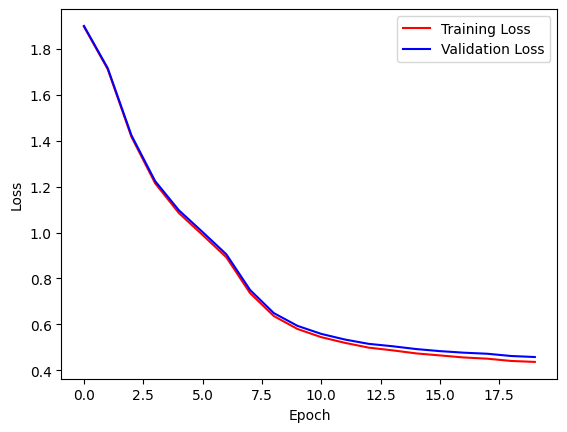

In [7]:
mlp.plot_loss()

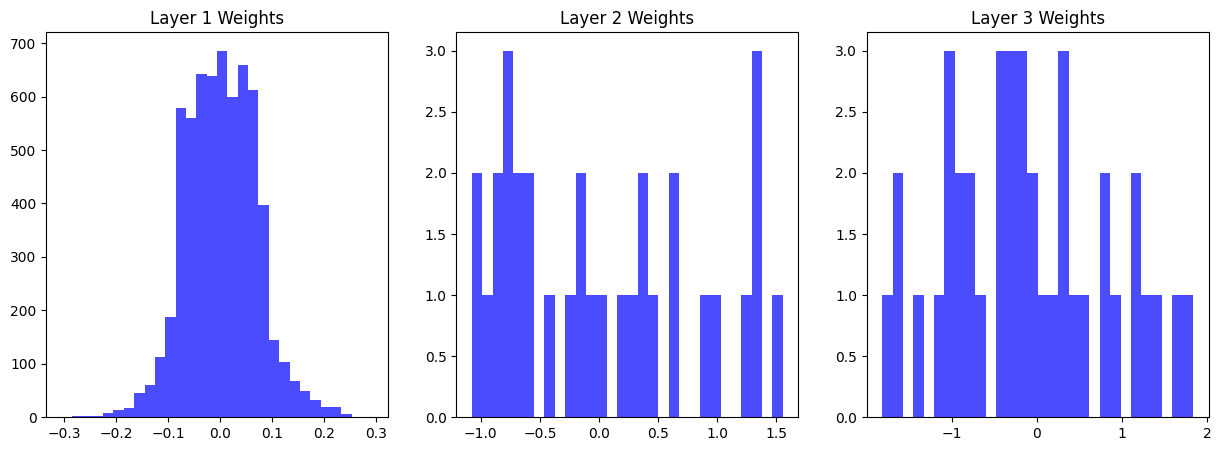

In [8]:
mlp.plot_weight_distribution()


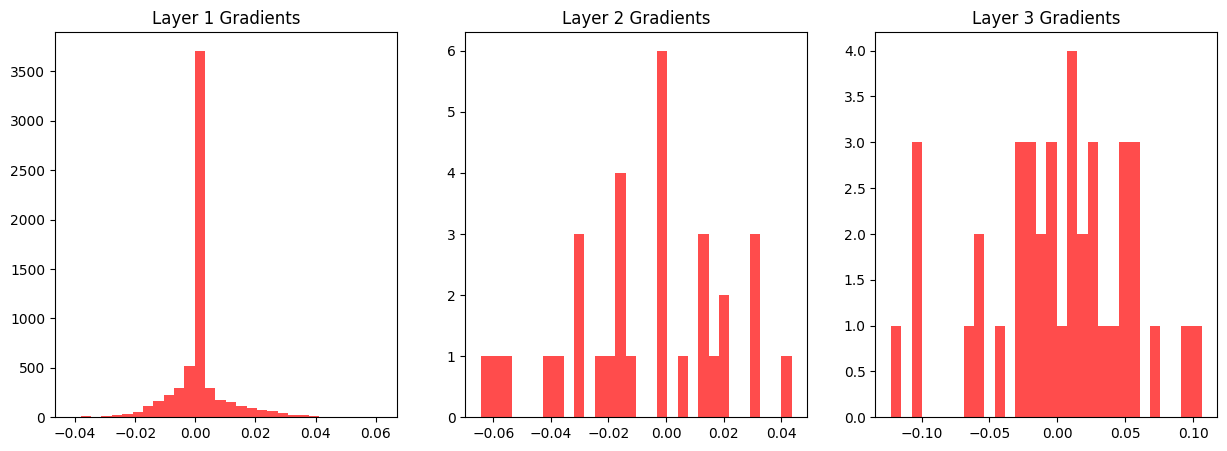

In [9]:
mlp.plot_gradient_distribution()

# Testing graph skala kecil

Training: 100%|██████████| 5/5 [00:00<00:00, 185.04epoch/s, accuracy=35.60%, train_loss=1.0979, val_loss=1.1000]

Test Accuracy: 29.00%


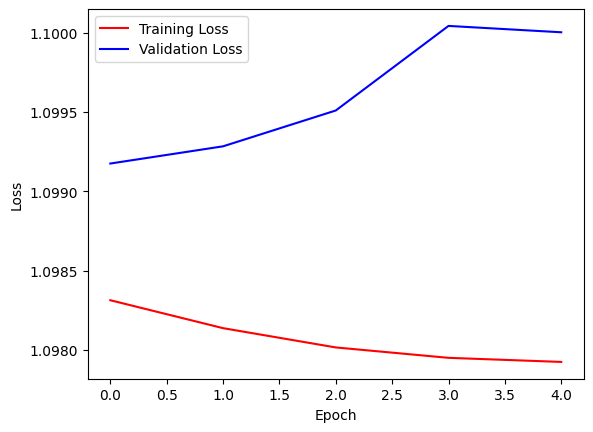

In [ ]:

np.random.seed(42)
X_train = np.random.rand(500, 5)  
y_train = np.eye(3)[np.random.choice(3, 500)] 

X_test = np.random.rand(100, 5)  # 100 sampel untuk validasi
y_test = np.eye(3)[np.random.choice(3, 100)]  # 100 label validasi

input_layer = Layer(input_size=5, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_1 = Layer(input_size=8, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=3, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')

layers = [input_layer, hidden_layer_1, hidden_layer_2, output_layer]

mlp = MLP(layers=layers, loss_function='cce', lr=0.1)

mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=5, batch_size=50)

test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")

mlp.plot_loss()

dot = draw_mlp(mlp)



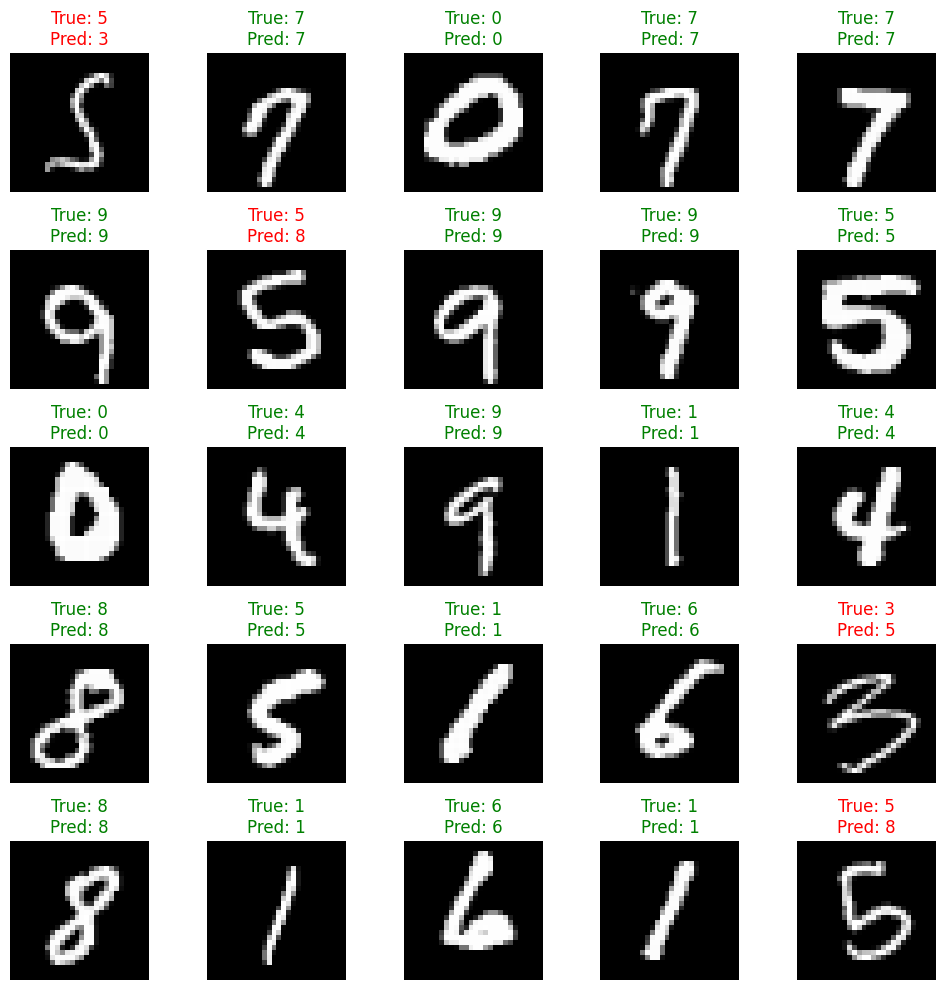

In [15]:
SAMPLE_SIZE = 25

random_indices = np.random.choice(len(X_test), SAMPLE_SIZE, replace=False)

X_sample = X_test[random_indices]
y_sample = y_test[random_indices]

y_pred = mlp.predict(X_sample)

if len(y_pred.shape) > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

y_true_labels = np.argmax(y_sample, axis=1)

grid_size = math.ceil(math.sqrt(SAMPLE_SIZE))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))

axes = axes.flatten()

for i in range(SAMPLE_SIZE):
    ax = axes[i]
    ax.imshow(X_sample[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}", 
                 color="green" if y_true_labels[i] == y_pred_labels[i] else "red")
    ax.axis("off")

for i in range(SAMPLE_SIZE, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

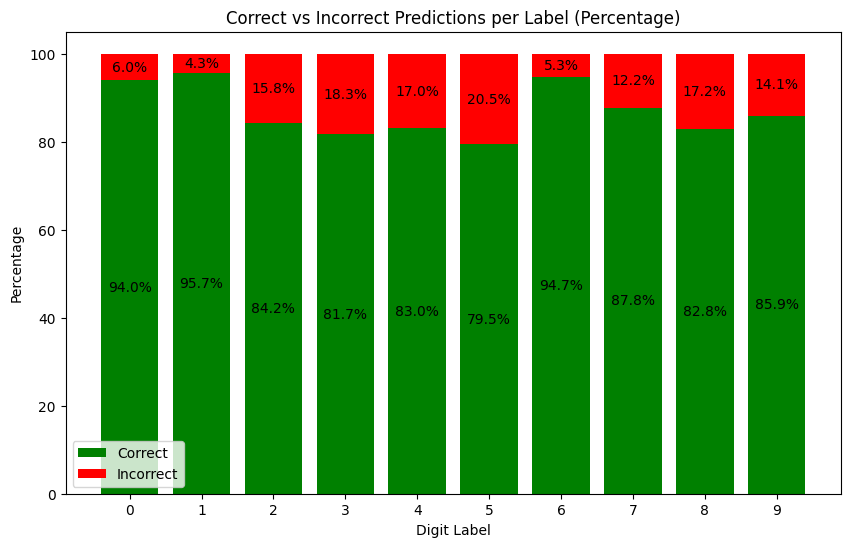

In [11]:
y_pred = mlp.predict(X_test)

if len(y_pred.shape) > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

y_true_labels = np.argmax(y_test, axis=1)

labels = np.arange(10)
correct_values = np.zeros(10, dtype=int)
incorrect_values = np.zeros(10, dtype=int)
total_values = np.zeros(10, dtype=int)

for true, pred in zip(y_true_labels, y_pred_labels):
    total_values[true] += 1
    if true == pred:
        correct_values[true] += 1
    else:
        incorrect_values[true] += 1

correct_percent = (correct_values / total_values) * 100
incorrect_percent = (incorrect_values / total_values) * 100

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(labels, correct_percent, color='green', label='Correct')
bars2 = ax.bar(labels, incorrect_percent, bottom=correct_percent, color='red', label='Incorrect')

for bar1, bar2, c_pct, i_pct in zip(bars1, bars2, correct_percent, incorrect_percent):
    ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() / 2, f'{c_pct:.1f}%', ha='center', va='center', fontsize=10, color='black')
    ax.text(bar2.get_x() + bar2.get_width() / 2, bar1.get_height() + bar2.get_height() / 2, f'{i_pct:.1f}%', ha='center', va='center', fontsize=10, color='black')

ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.set_xlabel("Digit Label")
ax.set_ylabel("Percentage")
ax.set_title("Correct vs Incorrect Predictions per Label (Percentage)")
ax.legend()

plt.show()

# Analysis Experiment

#### 2.2.2 Pengaruh Depth and Width



Training network with width=8_depth=1


Training: 100%|██████████| 10/10 [00:05<00:00,  1.81epoch/s, accuracy=92.62%, train_loss=0.2491, val_loss=0.2965]


Test Accuracy: 91.13%


Training network with width=8_depth=2


Training: 100%|██████████| 10/10 [00:05<00:00,  1.69epoch/s, accuracy=92.48%, train_loss=0.2462, val_loss=0.2869]


Test Accuracy: 91.55%


Training network with width=8_depth=3


Training: 100%|██████████| 10/10 [00:05<00:00,  1.70epoch/s, accuracy=93.30%, train_loss=0.2319, val_loss=0.2753]


Test Accuracy: 92.13%


Training network with width=16_depth=1


Training: 100%|██████████| 10/10 [00:06<00:00,  1.46epoch/s, accuracy=95.70%, train_loss=0.1471, val_loss=0.1980]


Test Accuracy: 94.25%


Training network with width=16_depth=2


Training: 100%|██████████| 10/10 [00:07<00:00,  1.32epoch/s, accuracy=96.03%, train_loss=0.1285, val_loss=0.1918]


Test Accuracy: 94.61%


Training network with width=16_depth=3


Training: 100%|██████████| 10/10 [00:08<00:00,  1.17epoch/s, accuracy=96.66%, train_loss=0.1103, val_loss=0.1657]


Test Accuracy: 95.09%


Training network with width=32_depth=1


Training: 100%|██████████| 10/10 [00:13<00:00,  1.38s/epoch, accuracy=97.30%, train_loss=0.0904, val_loss=0.1349]


Test Accuracy: 95.84%


Training network with width=32_depth=2


Training: 100%|██████████| 10/10 [00:15<00:00,  1.59s/epoch, accuracy=97.73%, train_loss=0.0721, val_loss=0.1363]


Test Accuracy: 95.98%


Training network with width=32_depth=3


Training: 100%|██████████| 10/10 [01:19<00:00,  7.94s/epoch, accuracy=97.52%, train_loss=0.0797, val_loss=0.1530]


Test Accuracy: 95.48%


Results Summary:
   Width  Depth  Test Accuracy  Training Time
0      8      1      91.128571       5.565459
1      8      2      91.552381       5.941520
2      8      3      92.128571       5.903484
3     16      1      94.247619       6.870665
4     16      2      94.609524       7.583890
5     16      3      95.090476       8.575344
6     32      1      95.838095      13.807628
7     32      2      95.980952      15.923450
8     32      3      95.476190      79.428002

Best Model Configuration:
Width: 32.0, Depth: 2.0
Accuracy: 95.98%
Training Time: 15.92 seconds


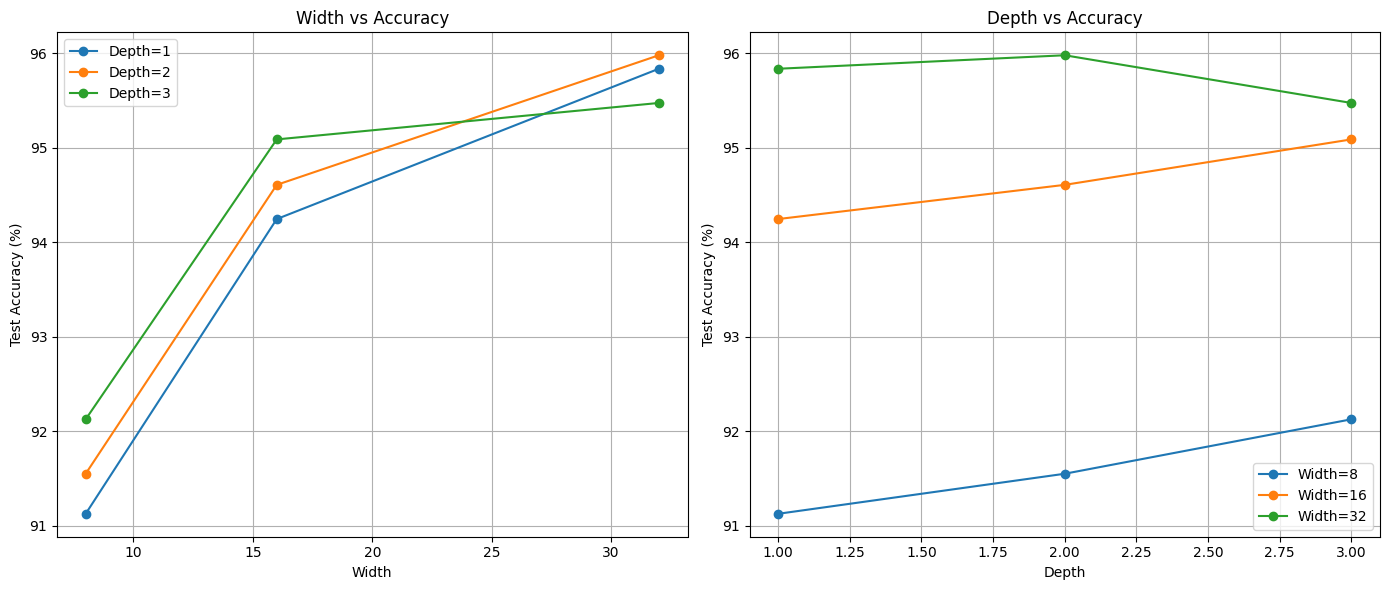

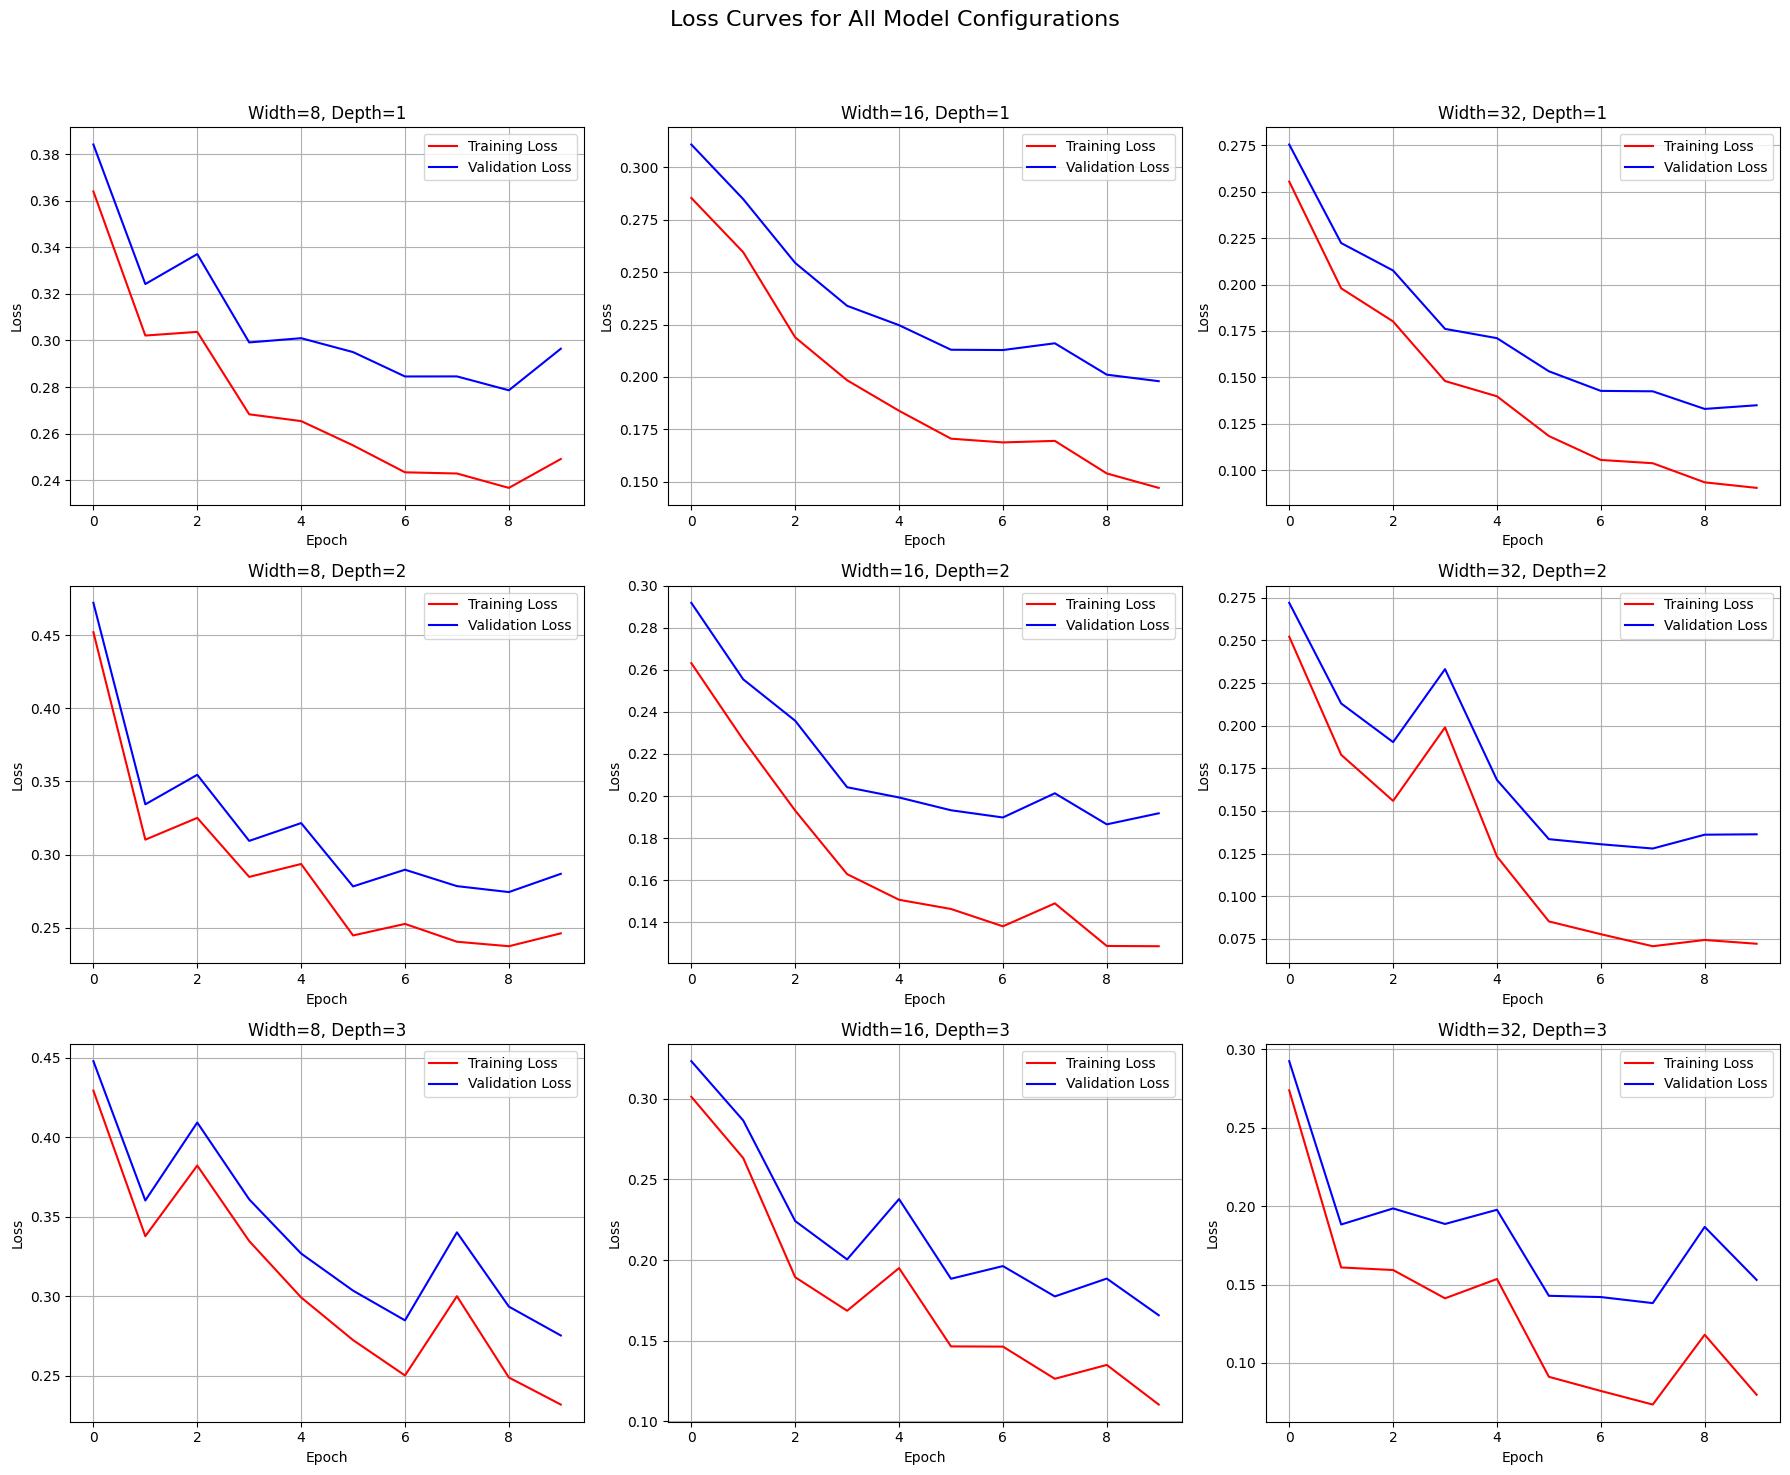

In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

width_variations = [8, 16, 32]  
depth_variations = [1, 2, 3]  

results = []
all_mlps = {} 

for width in width_variations:
    for depth in depth_variations:
        model_name = f"width={width}_depth={depth}"
        print(f"\n\nTraining network with {model_name}")
        
        layers = []
        
        layers.append(Layer(input_size=784, n_neurons=width, activation='relu', 
                           bias_init='zeros', seed=42, weight_init='he_uniform'))
        
        for i in range(depth-1):
            layers.append(Layer(input_size=width, n_neurons=width, activation='relu', 
                               bias_init='zeros', seed=42, weight_init='he_uniform'))
        
        layers.append(Layer(input_size=width, n_neurons=10, activation='softmax', 
                           bias_init='zeros', seed=42, weight_init='he_uniform'))
        
        mlp = MLP(layers=layers, loss_function='cce', lr=0.1)
        
        start_time = time.time()
        history = mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, 
                          epochs=10, batch_size=64)
        training_time = time.time() - start_time
        
        all_mlps[model_name] = mlp
        
        test_acc = mlp.accuracy(X_test, y_test)
        print(f"Test Accuracy: {test_acc:.2f}%")
        
        results.append({
            'Width': width,
            'Depth': depth,
            'Test Accuracy': test_acc,
            'Training Time': training_time,
        })

        
results_df = pd.DataFrame(results)
print("\n\nResults Summary:")
print(results_df)

best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"\nBest Model Configuration:")
print(f"Width: {best_model['Width']}, Depth: {best_model['Depth']}")
print(f"Accuracy: {best_model['Test Accuracy']:.2f}%")
print(f"Training Time: {best_model['Training Time']:.2f} seconds")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for depth in depth_variations:
    subset = results_df[results_df['Depth'] == depth]
    axes[0].plot(subset['Width'], subset['Test Accuracy'], marker='o', label=f'Depth={depth}')
    
axes[0].set_title('Width vs Accuracy')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].legend()
axes[0].grid(True)

for width in width_variations:
    subset = results_df[results_df['Width'] == width]
    axes[1].plot(subset['Depth'], subset['Test Accuracy'], marker='o', label=f'Width={width}')
    
axes[1].set_title('Depth vs Accuracy')
axes[1].set_xlabel('Depth')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Loss Curves for All Model Configurations', fontsize=16)

def plot_loss_on_axis(mlp, ax):
    ax.plot(mlp.loss_graph, label="Training Loss", color="red")
    ax.plot(mlp.valid_graph, label="Validation Loss", color="blue")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

for i, depth in enumerate(depth_variations):
    for j, width in enumerate(width_variations):
        model_name = f"width={width}_depth={depth}"
        ax = axes[i, j]
        plot_loss_on_axis(all_mlps[model_name], ax)
        ax.set_title(f"Width={width}, Depth={depth}")
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 2.2.3 Pengaruh Aktivasi Hidden Layer

aktivasi sigmoid


Training: 100%|██████████| 50/50 [00:28<00:00,  1.73epoch/s, accuracy=53.65%, train_loss=0.0706, val_loss=0.0707]


Test Accuracy (sigmoid): 53.61%
aktivasi relu


Training: 100%|██████████| 50/50 [00:35<00:00,  1.40epoch/s, accuracy=76.25%, train_loss=0.0366, val_loss=0.0368]


Test Accuracy (relu): 76.12%
aktivasi tanh


Training: 100%|██████████| 50/50 [00:49<00:00,  1.01epoch/s, accuracy=59.69%, train_loss=0.0553, val_loss=0.0556]


Test Accuracy (tanh): 59.38%
aktivasi linear


Training: 100%|██████████| 50/50 [00:56<00:00,  1.14s/epoch, accuracy=82.50%, train_loss=0.0339, val_loss=0.0341]


Test Accuracy (linear): 82.66%


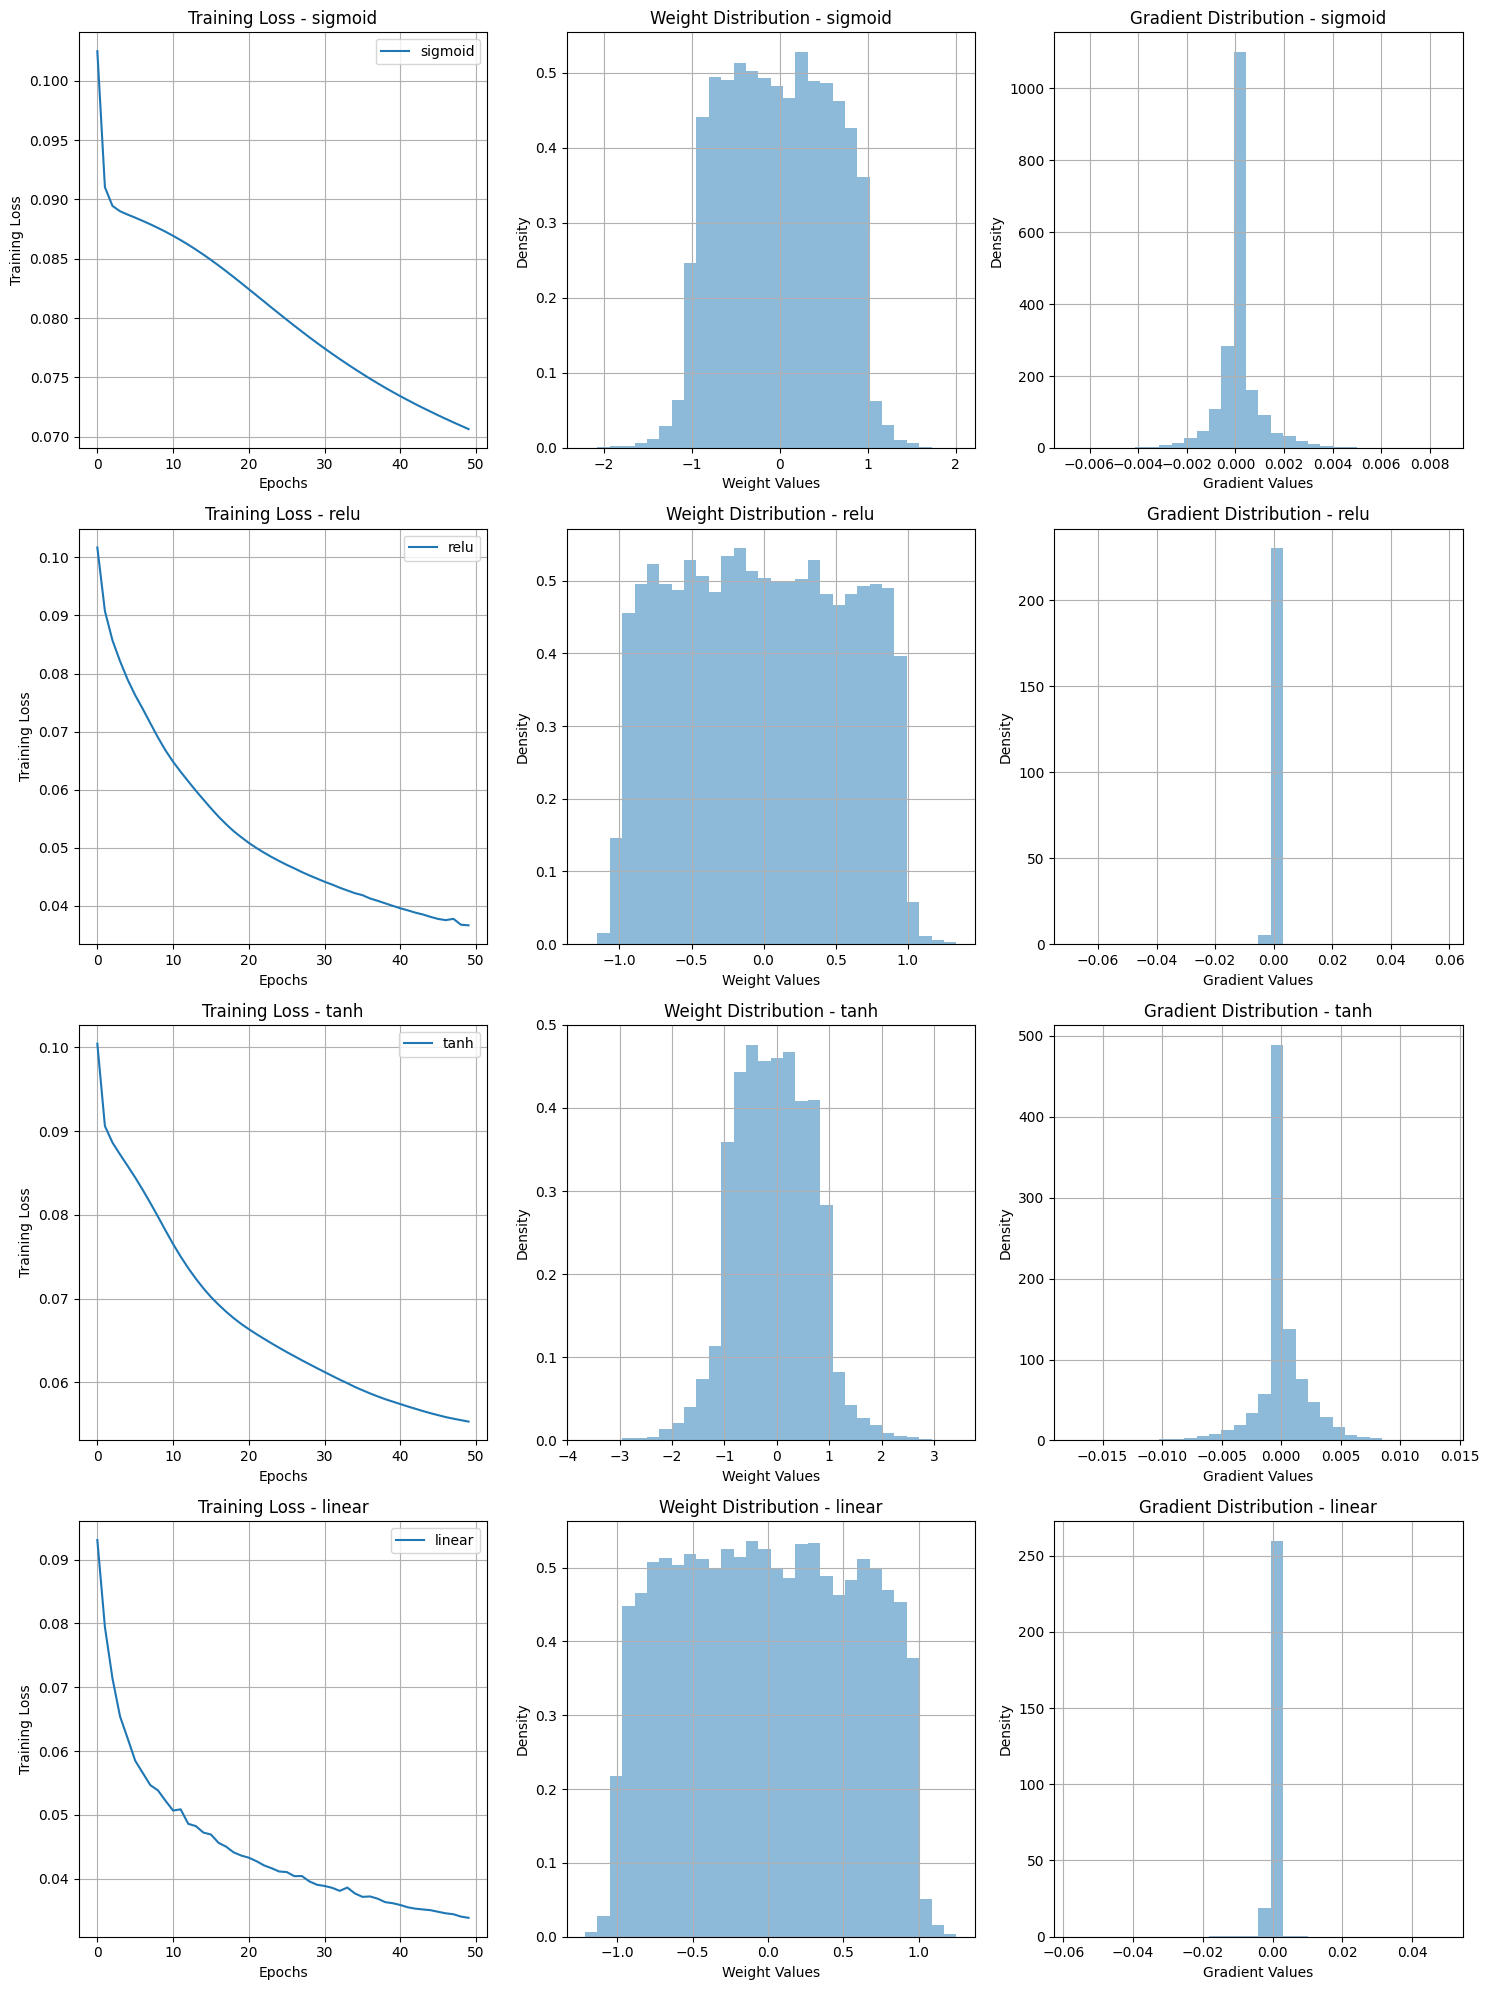

In [4]:
activation_functions = ["sigmoid", "relu", "tanh", "linear"]
results = {}

for activation in activation_functions:
    print(f"aktivasi {activation}")

    hidden_layer_1 = Layer(input_size=784, n_neurons=16, activation=activation, bias_init='zeros', seed=42, weight_init='random_uniform')
    hidden_layer_2 = Layer(input_size=16, n_neurons=8, activation=activation, bias_init='zeros', seed=42, weight_init='random_uniform')
    output_layer = Layer(input_size=8, n_neurons=10, activation='sigmoid', bias_init='zeros', seed=42, weight_init='random_uniform')
    layers = [hidden_layer_1, hidden_layer_2, output_layer]
    mlp = MLP(layers=layers, loss_function='mse', lr=0.1)
    mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=50, batch_size=1000,verbose=1)
    test_acc = mlp.accuracy(X_test, y_test)
    print(f"Test Accuracy ({activation}): {test_acc:.2f}%")

    results[activation] = {
        "loss_graph": mlp.loss_graph,
        "valid_graph": mlp.valid_graph,
        "weights_history": mlp.weights_history,
        "gradients_history": mlp.gradients_history
    }


def plot_comparison(results):
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    for i, (activation, res) in enumerate(results.items()):
        ax = axes[i, 0]
        ax.plot(res["loss_graph"], label=f"{activation}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training Loss")
        ax.set_title(f"Training Loss - {activation}")
        ax.legend()
        ax.grid(True)
        
        ax = axes[i, 1]
        weights = np.concatenate([np.ravel(w[-1]) for w in res["weights_history"].values()])
        ax.hist(weights, bins=30, alpha=0.5, density=True)
        ax.set_xlabel("Weight Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Weight Distribution - {activation}")
        ax.grid(True)
        
        ax = axes[i, 2]
        grads = np.concatenate([np.ravel(g[-1]) for g in res["gradients_history"].values()])
        ax.hist(grads, bins=30, alpha=0.5, density=True)
        ax.set_xlabel("Gradient Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Gradient Distribution - {activation}")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_comparison(results)


#### 2.2.4 Pengaruh Learning Rate

LR:  1


Training: 100%|██████████| 50/50 [00:25<00:00,  1.98epoch/s, accuracy=11.25%, train_loss=2.3012, val_loss=2.3012]


Test Accuracy (1): 11.25%
LR:  0.1


Training: 100%|██████████| 50/50 [00:32<00:00,  1.55epoch/s, accuracy=95.25%, train_loss=0.1662, val_loss=0.2055]


Test Accuracy (0.1): 94.15%
LR:  0.01


Training: 100%|██████████| 50/50 [00:49<00:00,  1.00epoch/s, accuracy=89.71%, train_loss=0.3565, val_loss=0.3762]


Test Accuracy (0.01): 89.45%


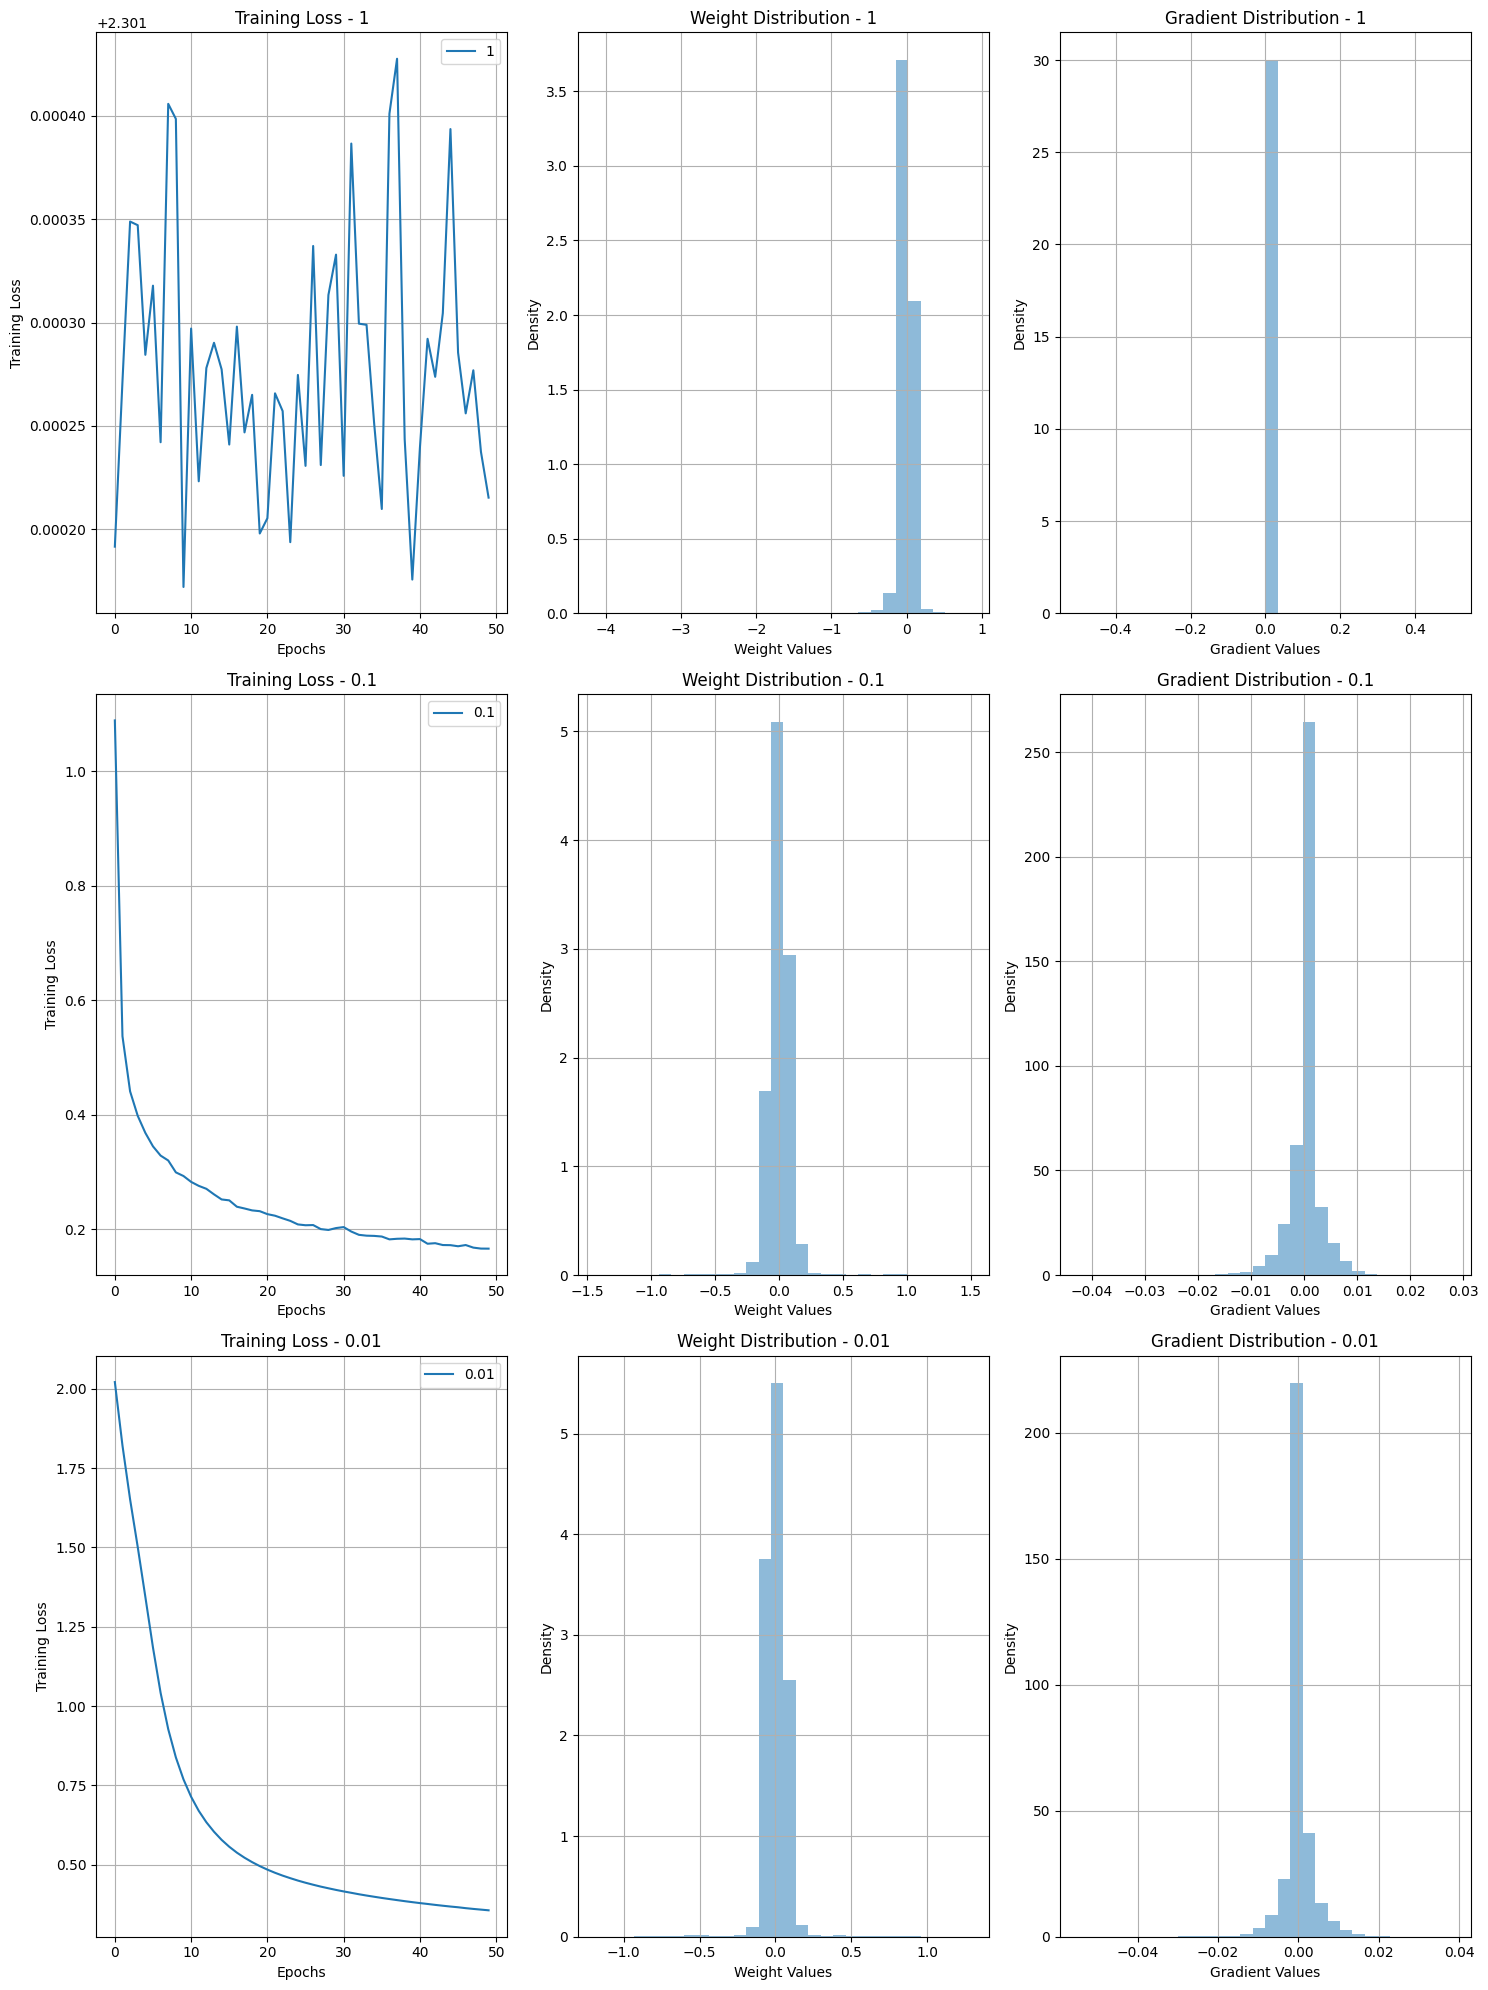

In [5]:
LR = [1,0.1,0.01]
results = {}
for a in LR:
    print(f"LR:  {a}")

    hidden_layer_1 = Layer(input_size=784, n_neurons=16, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
    hidden_layer_2 = Layer(input_size=16, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
    output_layer = Layer(input_size=8, n_neurons=10, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')
    layers = [hidden_layer_1, hidden_layer_2, output_layer]
    mlp = MLP(layers=layers, loss_function='cce', lr=a)
    mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=50, batch_size=1000,verbose=1)
    test_acc = mlp.accuracy(X_test, y_test)
    print(f"Test Accuracy ({a}): {test_acc:.2f}%")

    results[a] = {
        "loss_graph": mlp.loss_graph,
        "valid_graph": mlp.valid_graph,
        "weights_history": mlp.weights_history,
        "gradients_history": mlp.gradients_history
    }


def plot_comparison(results):
    fig, axes = plt.subplots(3, 3, figsize=(15, 20))
    
    for i, (activation, res) in enumerate(results.items()):
        ax = axes[i, 0]
        ax.plot(res["loss_graph"], label=f"{activation}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training Loss")
        ax.set_title(f"Training Loss - {activation}")
        ax.legend()
        ax.grid(True)
        
        ax = axes[i, 1]
        weights = np.concatenate([np.ravel(w[-1]) for w in res["weights_history"].values()])
        ax.hist(weights, bins=30, alpha=0.5, density=True)
        ax.set_xlabel("Weight Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Weight Distribution - {activation}")
        ax.grid(True)
        
        ax = axes[i, 2]
        grads = np.concatenate([np.ravel(g[-1]) for g in res["gradients_history"].values()])
        ax.hist(grads, bins=30, alpha=0.5, density=True)
        ax.set_xlabel("Gradient Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Gradient Distribution - {activation}")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_comparison(results)


#### 2.2.5 Pengaruh Bobot



Training network with init=zeros


Training: 100%|██████████| 10/10 [00:04<00:00,  2.18epoch/s, accuracy=11.25%, train_loss=2.3011, val_loss=2.3011]


Test Accuracy: 11.25%

Gradient Distribution for zeros:


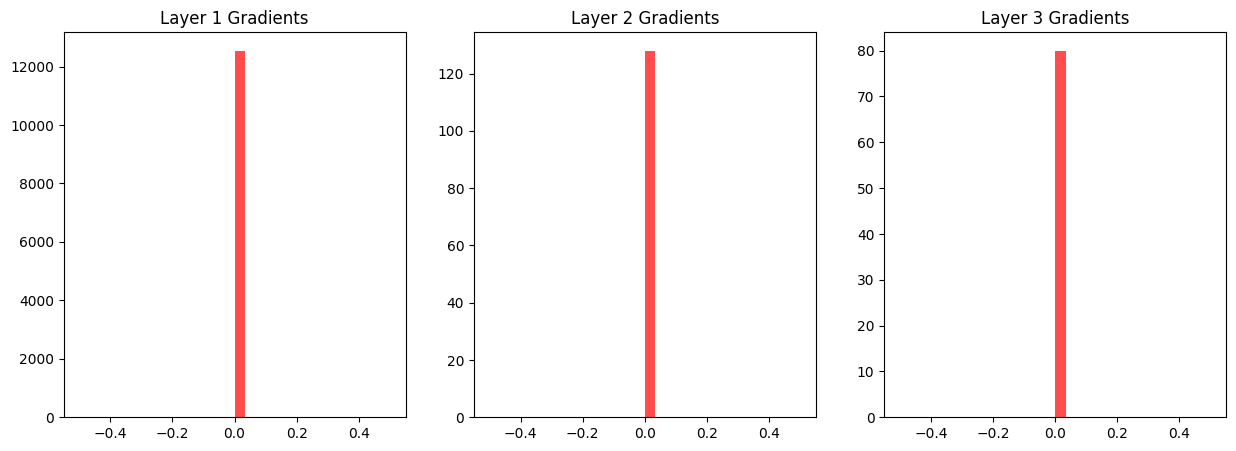



Training network with init=random_uniform


Training: 100%|██████████| 10/10 [00:04<00:00,  2.34epoch/s, accuracy=69.27%, train_loss=0.9360, val_loss=0.9444]


Test Accuracy: 69.11%

Gradient Distribution for random_uniform:


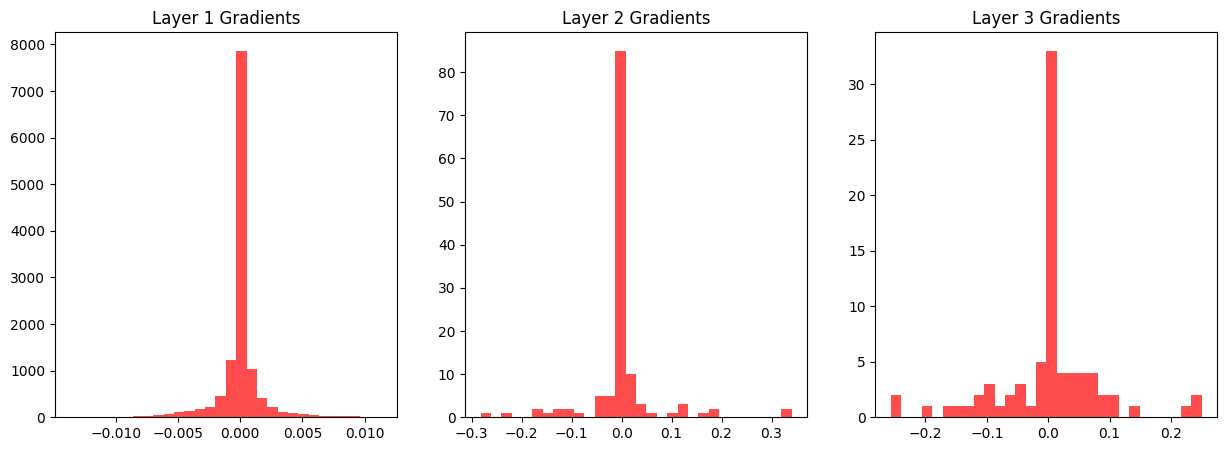



Training network with init=random_normal


Training: 100%|██████████| 10/10 [00:04<00:00,  2.27epoch/s, accuracy=17.59%, train_loss=2.1901, val_loss=2.1904]


Test Accuracy: 17.50%

Gradient Distribution for random_normal:


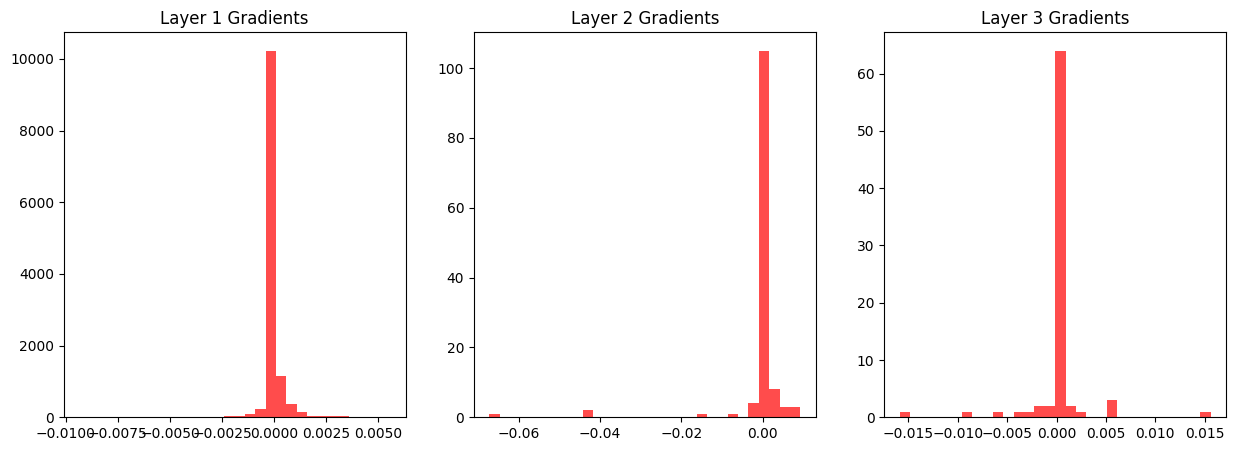



Training network with init=xavier_uniform


Training: 100%|██████████| 10/10 [00:04<00:00,  2.27epoch/s, accuracy=91.59%, train_loss=0.2931, val_loss=0.3161]


Test Accuracy: 90.98%

Gradient Distribution for xavier_uniform:


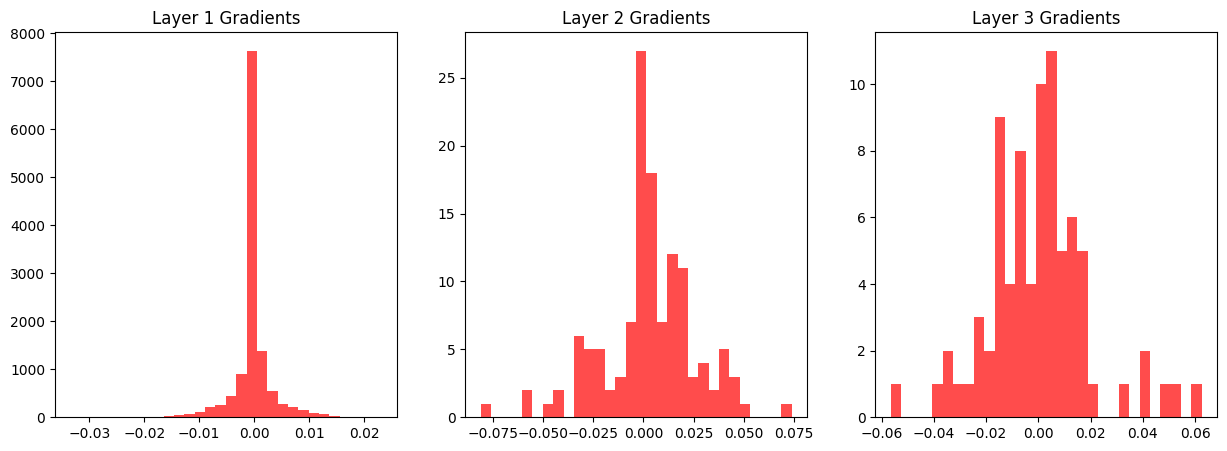



Training network with init=xavier_normal


Training: 100%|██████████| 10/10 [00:04<00:00,  2.18epoch/s, accuracy=88.25%, train_loss=0.4352, val_loss=0.4615]


Test Accuracy: 87.90%

Gradient Distribution for xavier_normal:


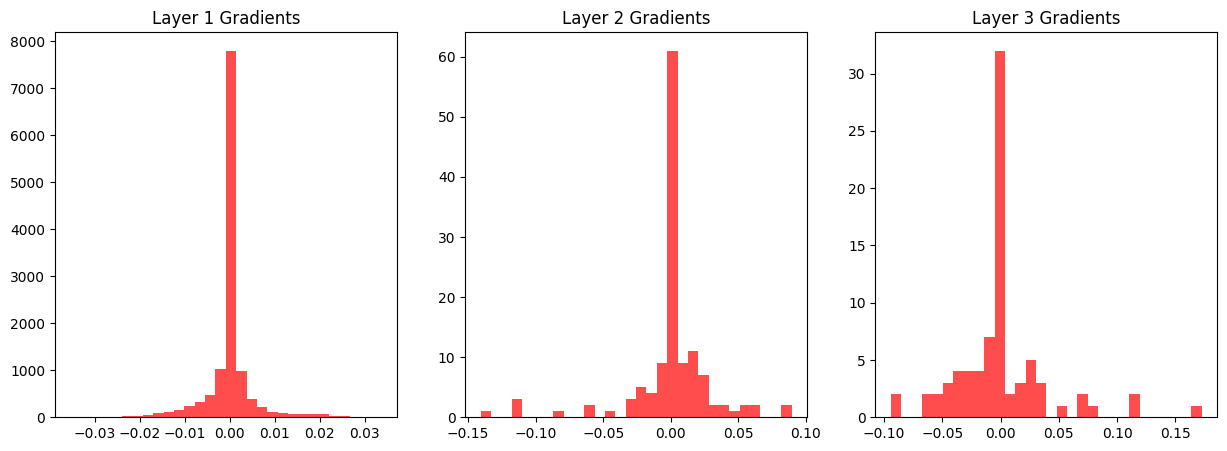



Training network with init=he_uniform


Training: 100%|██████████| 10/10 [00:04<00:00,  2.03epoch/s, accuracy=91.59%, train_loss=0.2931, val_loss=0.3161]


Test Accuracy: 90.98%

Gradient Distribution for he_uniform:


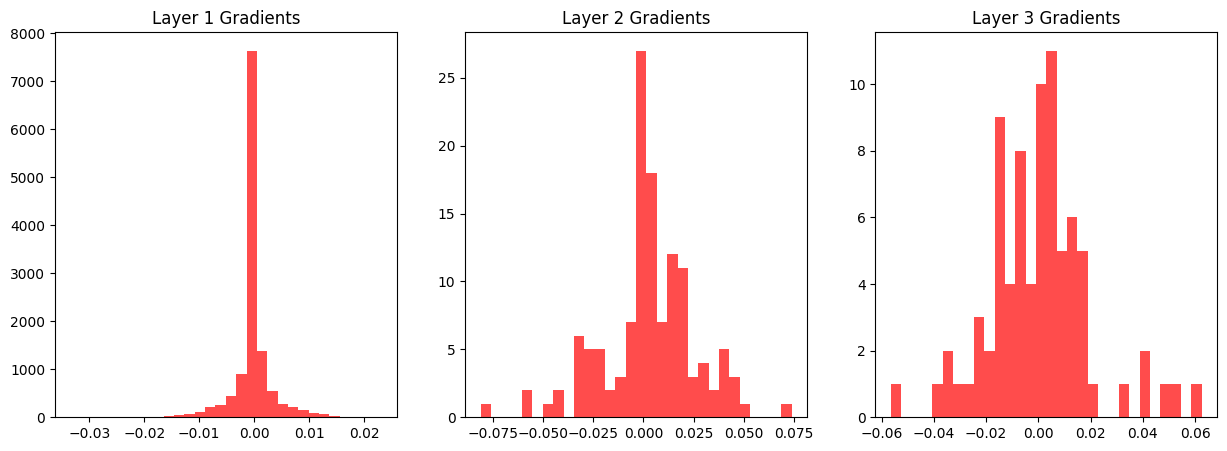



Training network with init=he_normal


Training: 100%|██████████| 10/10 [00:05<00:00,  1.81epoch/s, accuracy=88.25%, train_loss=0.4352, val_loss=0.4615]


Test Accuracy: 87.90%

Gradient Distribution for he_normal:


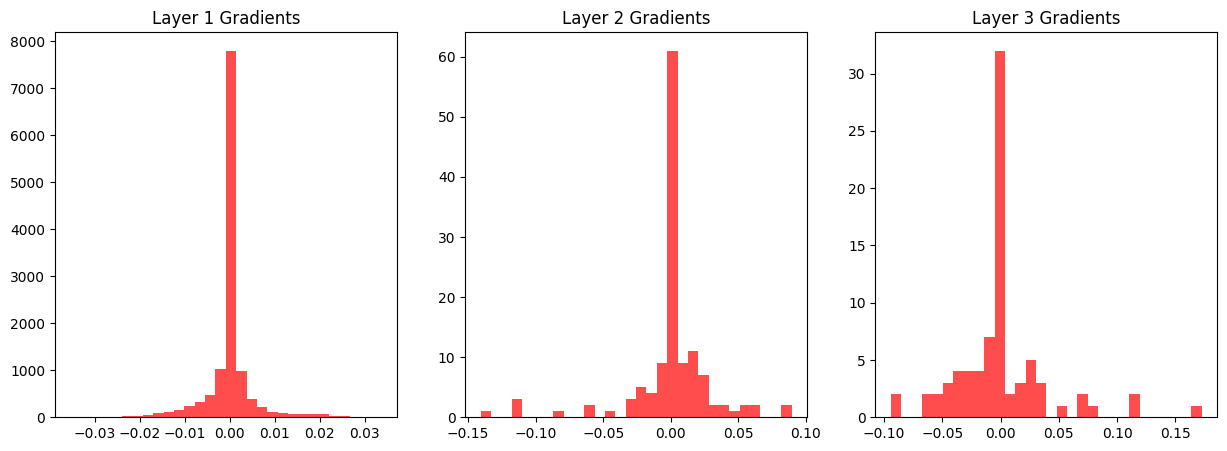



Results Summary:
   Initialization  Test Accuracy  Training Time
0           zeros      11.252381       4.616290
1  random_uniform      69.114286       4.304183
2   random_normal      17.500000       4.433278
3  xavier_uniform      90.976190       4.424896
4   xavier_normal      87.904762       4.603462
5      he_uniform      90.976190       4.938555
6       he_normal      87.904762       5.539939

Best Model Configuration:
Initialization: xavier_uniform
Accuracy: 90.98%
Training Time: 4.42 seconds


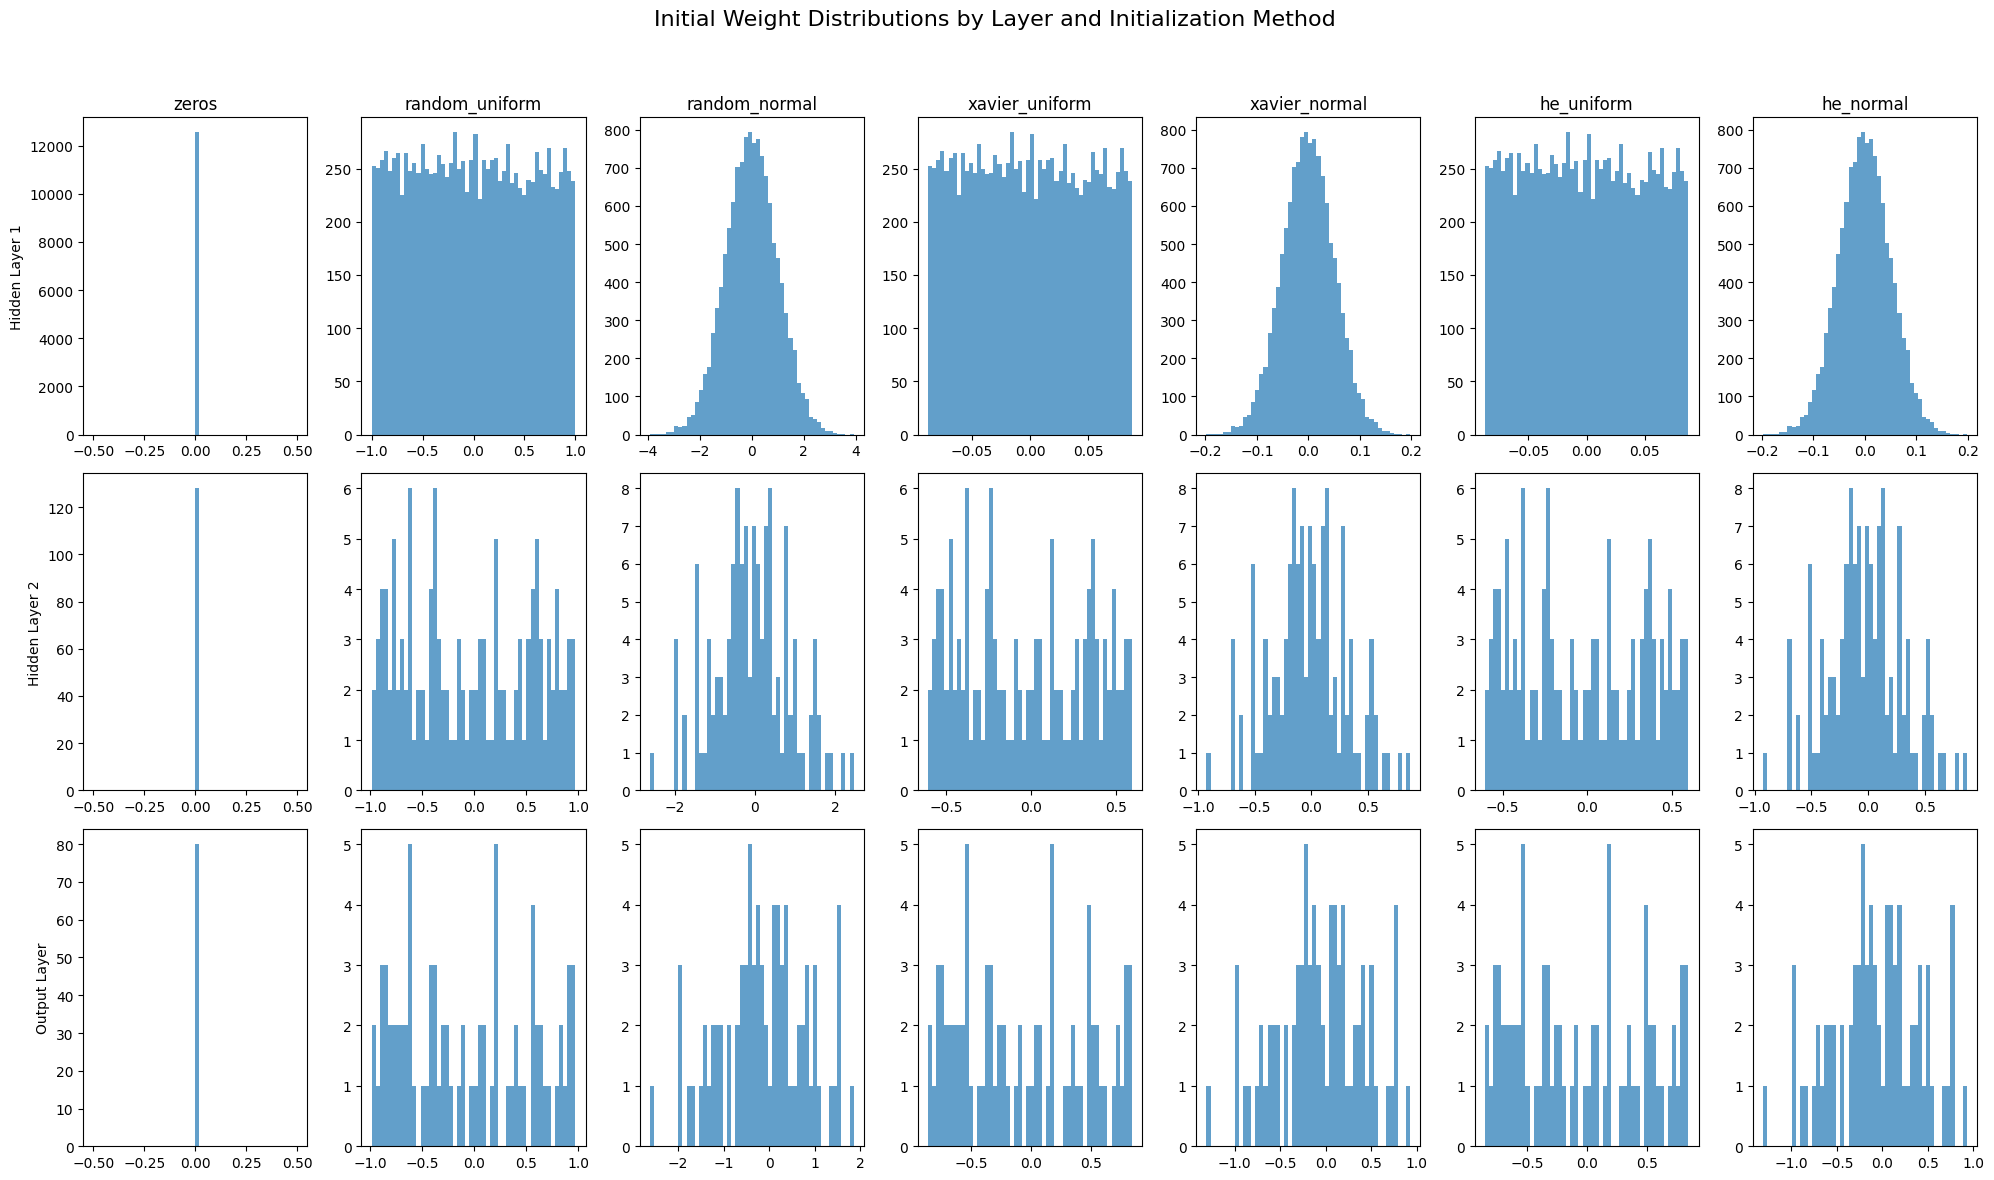

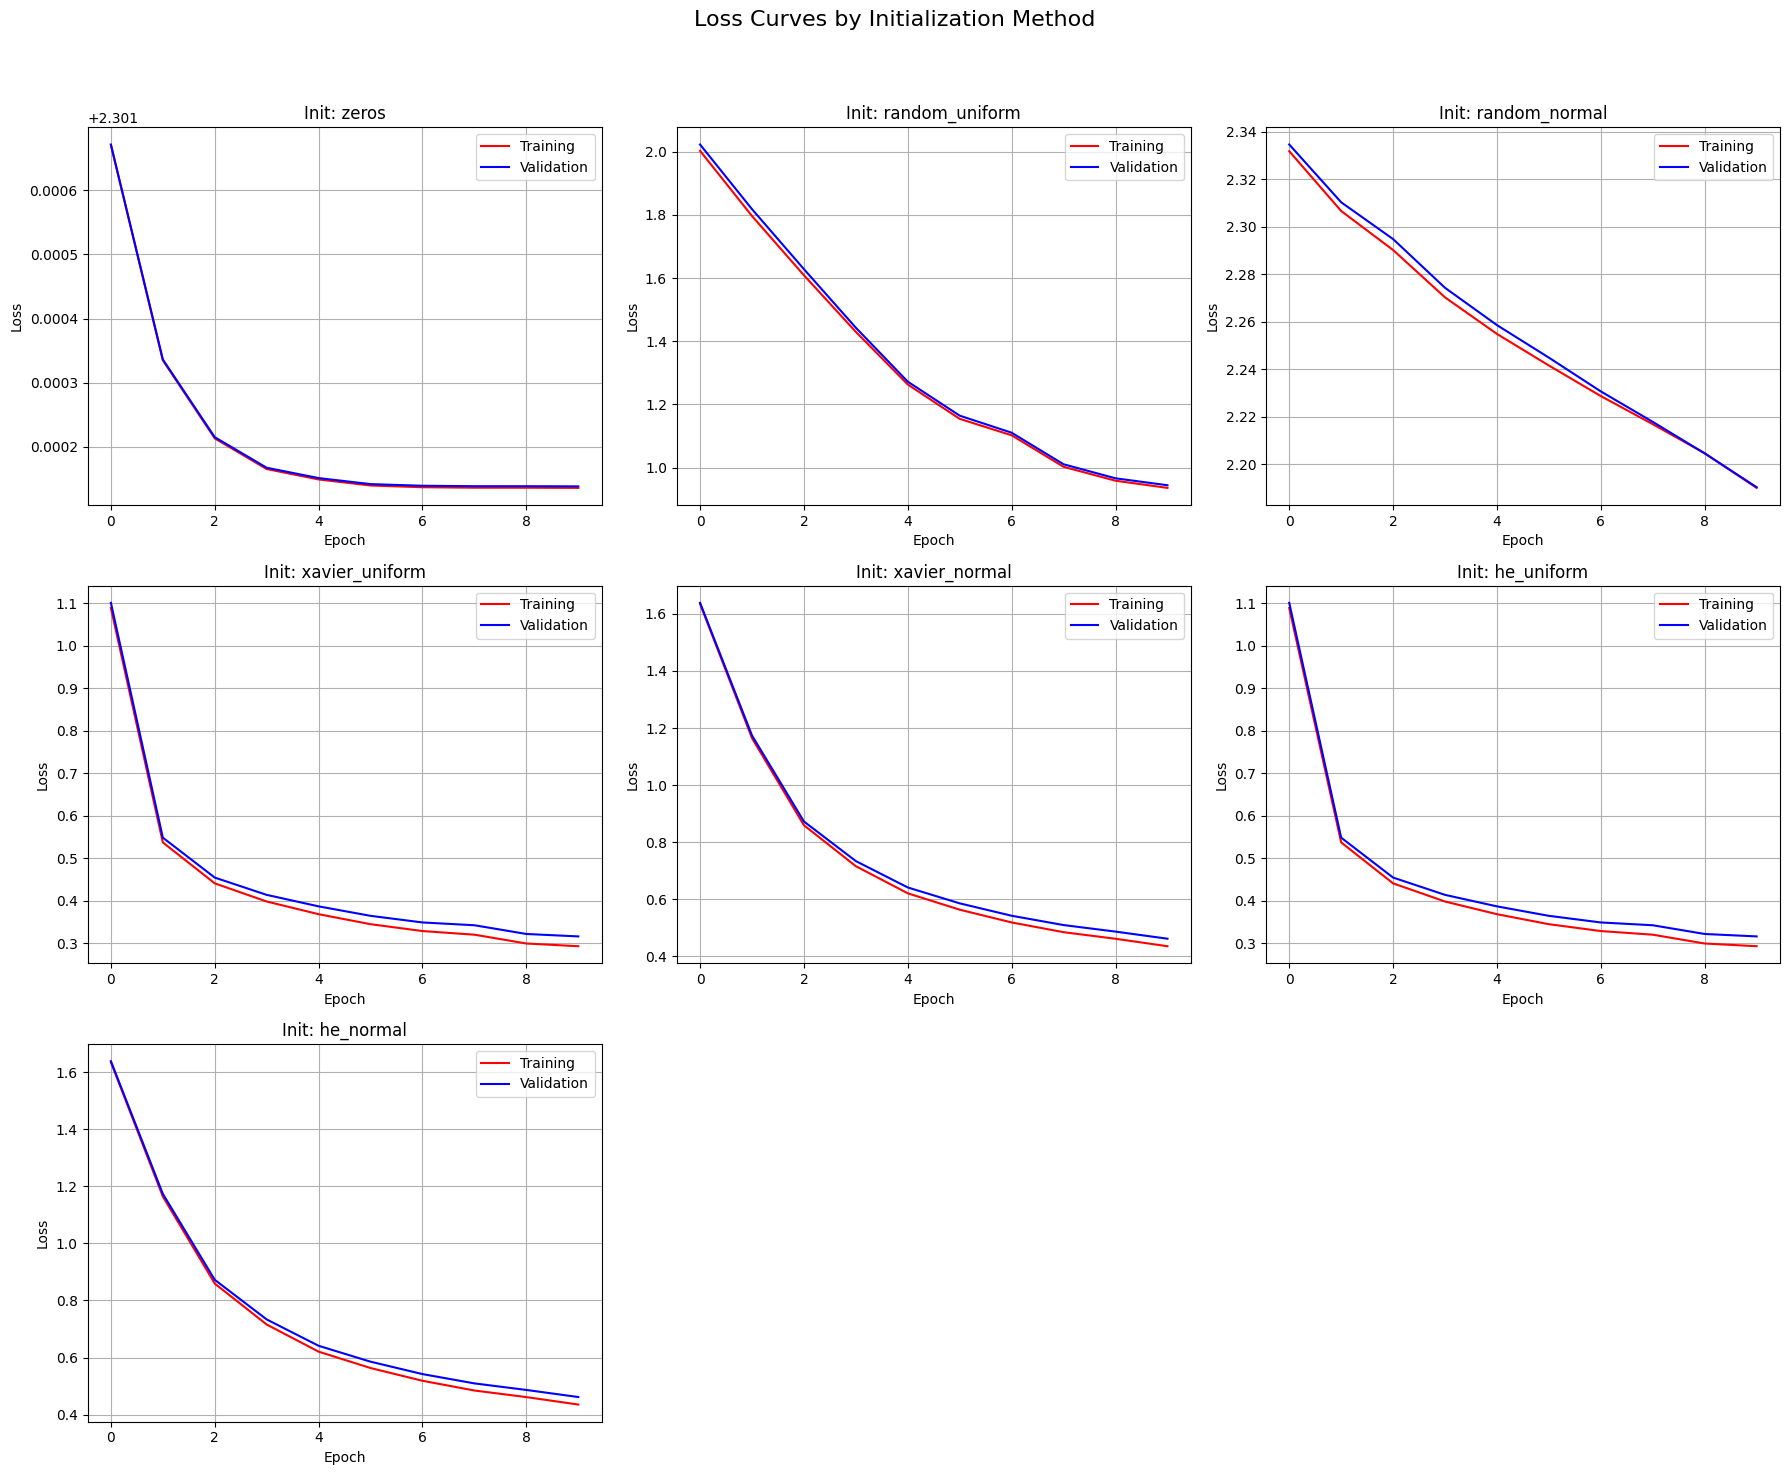

In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from lib.MLP import MLP, Layer  

weight_init_methods = ['zeros', 'random_uniform', 'random_normal', 'xavier_uniform', 'xavier_normal', 'he_uniform', 'he_normal']

results = []
all_mlps = {}
weight_distributions_before = {}
weight_distributions_after = {}

for init_method in weight_init_methods:
    model_name = f"init={init_method}"
    print(f"\n\nTraining network with {model_name}")
    
    hidden_layer_1 = Layer(input_size=784, n_neurons=16, activation='relu', 
                          bias_init='zeros', seed=42, weight_init=init_method)
    hidden_layer_2 = Layer(input_size=16, n_neurons=8, activation='relu', 
                          bias_init='zeros', seed=42, weight_init=init_method)
    output_layer = Layer(input_size=8, n_neurons=10, activation='softmax', 
                         bias_init='zeros', seed=42, weight_init=init_method)

    layers = [hidden_layer_1, hidden_layer_2, output_layer]
    
    weight_distributions_before[model_name] = {}
    for i, layer in enumerate(layers):
        weight_distributions_before[model_name][f'layer_{i}'] = layer.weights.copy()
    
    mlp = MLP(layers=layers, loss_function='cce', lr=0.1)
    
    start_time = time.time()
    mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10, batch_size=1000,verbose=1)
    training_time = time.time() - start_time
    
    all_mlps[model_name] = mlp
    
    weight_distributions_after[model_name] = {}
    for i, layer in enumerate(layers):
        weight_distributions_after[model_name][f'layer_{i}'] = layer.weights.copy()
    
    # Evaluate model
    test_acc = mlp.accuracy(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Store results
    results.append({
        'Initialization': init_method,
        'Test Accuracy': test_acc,
        'Training Time': training_time,
    })
    

    print(f"\nGradient Distribution for {init_method}:")
    
    mlp.plot_gradient_distribution()
    

results_df = pd.DataFrame(results)
print("\n\nResults Summary:")
print(results_df)

best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"\nBest Model Configuration:")
print(f"Initialization: {best_model['Initialization']}")
print(f"Accuracy: {best_model['Test Accuracy']:.2f}%")
print(f"Training Time: {best_model['Training Time']:.2f} seconds")


# Bobot Awal
fig, axes = plt.subplots(3, len(weight_init_methods), figsize=(20, 12))
fig.suptitle('Initial Weight Distributions by Layer and Initialization Method', fontsize=16)

for layer_idx in range(3):  
    for i, init_method in enumerate(weight_init_methods):
        model_name = f"init={init_method}"
        ax = axes[layer_idx, i]
        
        initial_weights = weight_distributions_before[model_name][f'layer_{layer_idx}'].flatten()
        ax.hist(initial_weights, bins=50, alpha=0.7)
        
        if layer_idx == 0:
            ax.set_title(init_method)
        
        if i == 0:
            if layer_idx == 0:
                ax.set_ylabel("Hidden Layer 1")
            elif layer_idx == 1:
                ax.set_ylabel("Hidden Layer 2")
            else:
                ax.set_ylabel("Output Layer")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

n_rows = (len(weight_init_methods) + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
fig.suptitle('Loss Curves by Initialization Method', fontsize=16)

if n_rows > 1:
    axes = axes.flatten()

for i, init_method in enumerate(weight_init_methods):
    model_name = f"init={init_method}"
    
    if n_rows == 1:
        if i < 3:
            ax = axes[i]
            ax.plot(all_mlps[model_name].loss_graph, label="Training", color="red")
            ax.plot(all_mlps[model_name].valid_graph, label="Validation", color="blue")
            ax.set_title(f"Init: {init_method}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)
    else:
        if i < len(axes):
            ax = axes[i]
            ax.plot(all_mlps[model_name].loss_graph, label="Training", color="red")
            ax.plot(all_mlps[model_name].valid_graph, label="Validation", color="blue")
            ax.set_title(f"Init: {init_method}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)

if n_rows > 1:
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 2.2.6 Perbandignan dengan Scikit

In [21]:
from sklearn.neural_network import MLPClassifier
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

X = X.to_numpy() / 255.0
y = y.astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


mlp = MLPClassifier(hidden_layer_sizes=(16, 8),
                    activation='relu',
                    batch_size=1000, 
                    solver='adam',
                    early_stopping=False,
                    warm_start=False, 
                    alpha=0,
                    learning_rate_init=0.01,
                    max_iter=50,
                    random_state=42,
                    verbose=False)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy_scikit = accuracy_score(y_test, y_pred) * 100

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


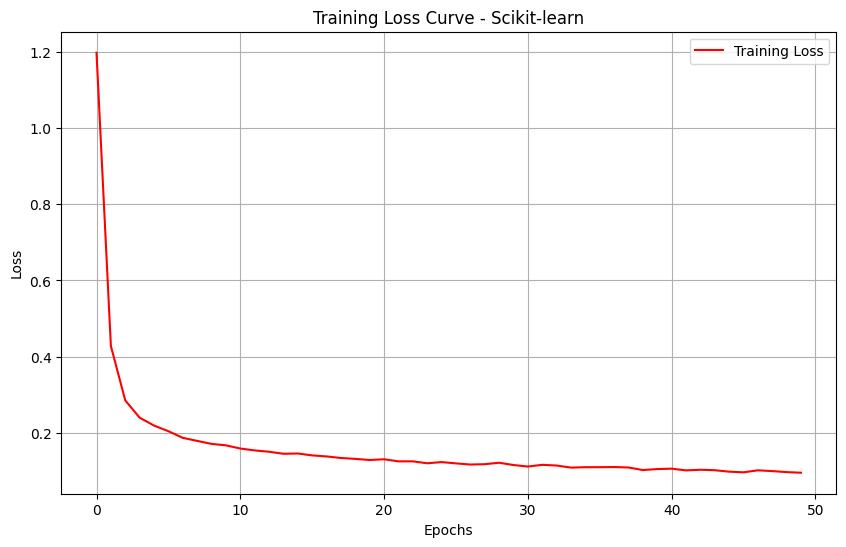

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mlp.loss_curve_, label="Training Loss", color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Curve - Scikit-learn")
ax.legend()
ax.grid(True)
plt.show()


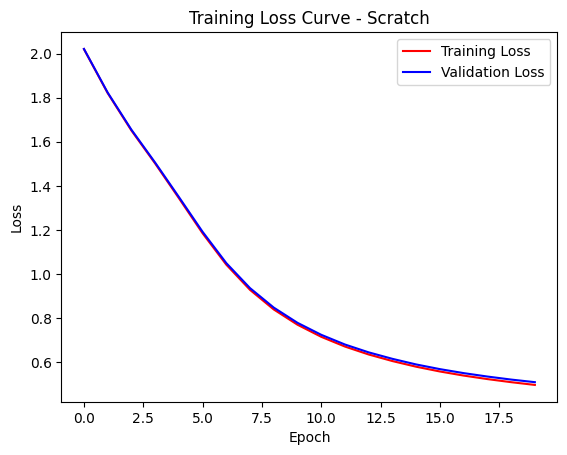

Scratch Accuracy: 85.74%
Scikit-learn Model Accuracy: 93.97%


In [23]:
#scratch

mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

X = X.to_numpy() / 255.0  
y = y.astype(int).to_numpy()  

def one_hot(y, num_classes=10):
    one_hot_encoded = np.zeros((y.shape[0], num_classes))
    one_hot_encoded[np.arange(y.shape[0]), y] = 1
    return one_hot_encoded

y = one_hot(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

hidden_layer_1 = Layer(input_size=784, n_neurons=16, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=16, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform') 
output_layer = Layer(input_size=8, n_neurons=10, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')
layers = [hidden_layer_1, hidden_layer_2, output_layer]
mlp_scratch = MLP(layers=layers, loss_function='cce', lr=0.01)
mlp_scratch.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20, batch_size=1000,verbose=0)


test_acc = mlp_scratch.accuracy(X_test, y_test)

# Plot loss

plt.title("Training Loss Curve - Scratch")
mlp_scratch.plot_loss()

print(f"Scratch Accuracy: {test_acc:.2f}%")
print(f"Scikit-learn Model Accuracy: {accuracy_scikit:.2f}%")